In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from pprint import pprint

# Base Processing

### Read in training & test data

In [2]:
# Load CSV to Dataframe
PATH = 'data/'
FILE_train = 'XYtr.csv'
FILE_test = 'Xte.csv'
IMG = 'image_class.csv'

raw_train = pd.read_csv(PATH + FILE_train)
raw_test = pd.read_csv(PATH + FILE_test)
img_file = pd.read_csv(PATH + IMG)

# Description, version, symbol, fee1, and fee2 have missing values (NaN)
print(raw_train.info())
print()
print(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3   description  6512 non-null   object 
 4   version      6746 non-null   object 
 5   symbol       5555 non-null   object 
 6   ext          6914 non-null   object 
 7   fee1         6696 non-null   float64
 8   fee2         6705 non-null   float64
 9   total        6914 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 540.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3 

In [3]:
raw_train = raw_train.merge(img_file, on = 'id', how = 'left')
raw_test = raw_test.merge(img_file, on = 'id', how = 'left')

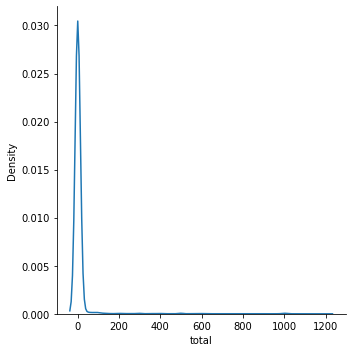

In [4]:
sns.displot(raw_train, x="total", kind="kde")

### size of the dataframe

In [5]:
print('raw_train shape: ', raw_train.shape)
print('raw_test shape: ', raw_test.shape)

raw_train shape:  (6914, 12)
raw_test shape:  (6914, 11)


### description

In [6]:
print('raw_train description missing values: ', raw_train['description'].isnull().sum())
print('raw_test description missing values: ', raw_test['description'].isnull().sum())

raw_train description missing values:  402
raw_test description missing values:  377


### version

In [7]:
print('raw_train version: ', raw_train['version'].unique())
print('raw_test version: ', raw_test['version'].unique())

raw_train version:  ['3' 'None' 'unsupported' '4' nan '1' '2']
raw_test version:  ['3' '4' 'None' nan 'unsupported' '1' '2']


In [8]:
print('raw_train version missing values: ', raw_train['version'].isnull().sum())
print('raw_test version missing values: ', raw_test['version'].isnull().sum())

raw_train version missing values:  168
raw_test version missing values:  154


### symbol

In [9]:
# https://stackoverflow.com/questions/45759966/counting-unique-values-in-a-column-in-pandas-dataframe-like-in-qlik/45760042
print('raw_train symbol: ', raw_train['symbol'].nunique())
print('raw_test symbol: ', raw_test['symbol'].nunique())

raw_train symbol:  417
raw_test symbol:  415


In [10]:
print('raw_train symbol missing values: ', raw_train['symbol'].isnull().sum())
print('raw_test symbol missing values: ', raw_test['symbol'].isnull().sum())

raw_train symbol missing values:  1359
raw_test symbol missing values:  1382


### ext

In [11]:
print('raw_train ext: ', raw_train['ext'].unique())
print('raw_test ext: ', raw_test['ext'].unique())

raw_train ext:  ['.png' '.jpg' '.gif']
raw_test ext:  ['.png' '.gif' '.jpg']


### fee1

In [12]:
print('raw_train fee1 missing values: ', raw_train['fee1'].isnull().sum())
print('raw_test fee1 missing values: ', raw_test['fee1'].isnull().sum())

raw_train fee1 missing values:  218
raw_test fee1 missing values:  284


### fee2

In [13]:
print('raw_train fee2 missing values: ', raw_train['fee2'].isnull().sum())
print('raw_test fee2 missing values: ', raw_test['fee2'].isnull().sum())

raw_train fee2 missing values:  209
raw_test fee2 missing values:  276


In [14]:
train_clean = raw_train.copy()
test_clean = raw_test.copy()

### Data Cleaning for training

In [15]:
# description: use the token None to mean no description
train_clean['description'] = train_clean['description'].fillna('None')

# version: Has 'None' category. Set nan to 'None'. 
#print(train_train['version'].unique())
train_clean['version'] = train_clean['version'].fillna('None')

# symbol: 5 digit symbols. Set to 00000 to represent None.
# print(df_train['symbol'].unique())
train_clean['symbol'] = train_clean['symbol'].fillna('00000')

# image class
train_clean['image_class'] = train_clean['image_class'].fillna('None')

# fee1: Small number misssin. Fill with the mean.
#df_train['fee1'] = df_train['fee1'].fillna((df_train['fee1'].mean()))
# https://www.w3resource.com/python-exercises/pandas/missing-values/python-pandas-missing-values-exercise-14.php
train_clean['fee1'].fillna(train_clean['fee1'].median(), inplace=True)
                                           
# fee2: Small number misssin. Fill with the mean.
#df_train['fee2'] = df_train['fee2'].fillna((df_train['fee2'].mean()))
train_clean['fee2'].fillna(train_clean['fee2'].median(), inplace=True)

# removing outliers
train_clean = train_clean[np.abs(train_clean['total']-train_clean['total'].mean()) <= (4*train_clean['total'].std())]

# https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-dataframe
train_clean.reset_index(drop=True, inplace=True)

print(train_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6842 entries, 0 to 6841
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6842 non-null   object 
 1   X.sales      6842 non-null   int64  
 2   cdate        6842 non-null   object 
 3   description  6842 non-null   object 
 4   version      6842 non-null   object 
 5   symbol       6842 non-null   object 
 6   ext          6842 non-null   object 
 7   fee1         6842 non-null   float64
 8   fee2         6842 non-null   float64
 9   total        6842 non-null   float64
 10  image_class  6842 non-null   object 
 11  score        4352 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 641.6+ KB
None


### Data Cleaning for test

In [16]:
# description: use the token None to mean no description
test_clean['description'] = test_clean['description'].fillna('None')

# version: Has 'None' category. Set nan to 'None'. 
test_clean['version'] = test_clean['version'].fillna('None')

# symbol: 5 digit symbols. Set to 00000 to represent None.
test_clean['symbol'] = test_clean['symbol'].fillna('00000')

# image class
test_clean['image_class'] = test_clean['image_class'].fillna('None')

# fee1: Small number misssin. Fill with the mean.
test_clean['fee1'].fillna(test_clean['fee1'].median(), inplace=True)
                                           
# fee2: Small number misssin. Fill with the mean.
test_clean['fee2'].fillna(test_clean['fee2'].median(), inplace=True)

print(test_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6914 entries, 0 to 6913
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3   description  6914 non-null   object 
 4   version      6914 non-null   object 
 5   symbol       6914 non-null   object 
 6   ext          6914 non-null   object 
 7   fee1         6914 non-null   float64
 8   fee2         6914 non-null   float64
 9   image_class  6914 non-null   object 
 10  score        4462 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 648.2+ KB
None


### Data preprocessing for training & test

In [17]:
train_processed = train_clean.copy()
test_processed = test_clean.copy()

In [18]:
# cdate: change dates to float
tr_date = train_processed['cdate']
train_processed['cdate'] = pd.to_datetime(tr_date).values.astype(np.float64)/8.64e+13

te_date = test_processed['cdate']
test_processed['cdate'] = pd.to_datetime(te_date).values.astype(np.float64)/8.64e+13

In [19]:
# X.sales: change from int to float
train_processed['X.sales'] = train_processed['X.sales'].astype(np.float64)
test_processed['X.sales'] = test_processed['X.sales'].astype(np.float64)

In [20]:
# obtain unique values from each dataset
train_symbols = set(train_processed['symbol'].unique())
test_symbols = set(test_processed['symbol'].unique())

# union all the values
# https://stackoverflow.com/questions/52976664/python-differences-between-two-lists
# # https://www.programiz.com/python-programming/methods/set/union
all_symbols = train_symbols.union(test_symbols)

# https://www.geeksforgeeks.org/python-intersection-two-lists/
# symbols that appear in both datasets
intersect_symbols = list(train_symbols & test_symbols)

# values not included in train set
train_required_symbols = list(all_symbols - train_symbols)

# values not included in test set
test_required_symbols = list(all_symbols - test_symbols)

In [21]:
# https://stackoverflow.com/questions/55839568/python-add-same-prefix-to-all-elements-in-list
drop_sym = list(all_symbols - set(intersect_symbols))
drop_sym = ['symbol_' + x for x in drop_sym]

In [22]:
# one-hot encoding on version, symbol and ext
train_processed = pd.get_dummies(train_processed, columns = ['version', 'ext', 'symbol'], drop_first = False, prefix = ['version', 'ext', 'symbol'])
test_processed = pd.get_dummies(test_processed, columns = ['version', 'ext', 'symbol'], drop_first = False, prefix = ['version', 'ext', 'symbol'])

In [23]:
# https://stackoverflow.com/questions/18674064/how-do-i-insert-a-column-at-a-specific-column-index-in-pandas
for train_syms in train_required_symbols:
    train_processed.insert(train_processed.shape[1], str('symbol_') + train_syms, 0)

/home/pop21/Documents/STAT-440/nft/jason/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [24]:
for test_syms in test_required_symbols:
    test_processed.insert(test_processed.shape[1], str('symbol_') + test_syms, 0)

In [25]:
# obtain unique values from each dataset
train_img_class = set(train_processed['image_class'].unique())
test_img_class = set(test_processed['image_class'].unique())

# union all the values
# https://stackoverflow.com/questions/52976664/python-differences-between-two-lists
# # https://www.programiz.com/python-programming/methods/set/union
all_img_class = train_img_class.union(test_img_class)

# https://www.geeksforgeeks.org/python-intersection-two-lists/
# symbols that appear in both datasets
intersect_img_class = list(train_img_class & test_img_class)

# values not included in train set
train_required_img_class = list(all_img_class - train_img_class)

# values not included in test set
test_required_img_class = list(all_img_class - test_img_class)

In [26]:
drop_img = list(all_img_class - set(intersect_img_class))
drop_img = ['image_class_' + x for x in drop_img]

In [27]:
# one-hot encoding on version, symbol and ext
train_processed = pd.get_dummies(train_processed, columns = ['image_class'], drop_first = False, prefix = ['image_class'])
test_processed = pd.get_dummies(test_processed, columns = ['image_class'], drop_first = False, prefix = ['image_class'])

In [28]:
for train_imgs in train_required_img_class:
    train_processed.insert(train_processed.shape[1], str('image_class_') + train_imgs, 0)

for test_imgs in test_required_img_class:
    test_processed.insert(test_processed.shape[1], str('image_class_') + test_imgs, 0)

In [29]:
train_base = train_processed.copy()
test_base = test_processed.copy()

In [30]:
train_base = train_base.drop(drop_img, axis = 1)
test_base = test_base.drop(drop_img, axis = 1)

print(train_base.shape)
print(test_base.shape)

(6842, 720)
(6914, 719)


# Text Feature Extraction

In [31]:
# Check for missing values before processing
print('train description missing values: ', train_base['description'].isnull().sum())
print('test description missing values: ', test_base['description'].isnull().sum())

train description missing values:  0
test description missing values:  0


### Create a corpus using training and test data

In [32]:
# Create corpus using training and test data
corpus = list(train_base['description'])+list(test_base['description'])

### Create a Document-Word matrix

In [33]:
# Create a Vectorizer Object
# remove tokens that appear in 10% of the documents
# remove unique tokens that appear in, at most, 2 documents
vectorizer = CountVectorizer(max_df=0.1, min_df=2)

In [34]:
# Encode the documents in a count matrix
corpus_vectorized = vectorizer.fit_transform(corpus)

In [35]:
# Feature names and size
print('feature name: ', vectorizer.get_feature_names_out())
print('feature size: ', len(vectorizer.get_feature_names_out()))

# dimension of a sparse matrix of documents (row) vs number of unique words
print('matrix dimension: ', corpus_vectorized.shape)

feature name:  ['002n7' '00b0d' '00jhg' ... 'zztgg' 'zzvdf' 'zzw3j']
feature size:  10518
matrix dimension:  (13756, 10518)


In [36]:
# A sparse matrix of documents (row) vs number of unique words
count_array = corpus_vectorized.toarray()
corpus_df = pd.DataFrame(data=count_array,columns = vectorizer.get_feature_names_out())
corpus_df

,002n7,00b0d,00jhg,00ud9,00xck,01abs,01fnu,01jsj,01k0e,01nrz,...,zzhb3,zzht0,zzlz3,zznp1,zzns7,zzpvk,zzr1c,zztgg,zzvdf,zzw3j
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Build a LDA model for topic modeling

In [37]:
lda_model = LatentDirichletAllocation(n_components = 100,
                                     learning_method = 'online',
                                      learning_decay = 0.9,
                                      random_state=100, 
                                      batch_size=128)

lda_output = lda_model.fit_transform(corpus_vectorized)

In [38]:
print(lda_output.shape)
print(lda_model)

(13756, 100)
LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          n_components=100, random_state=100)


### Separate the dataframe back to train and test

In [39]:
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
train_document_topic = pd.DataFrame(np.round(lda_output[0:6842,], 8), columns = topicnames)
test_document_topic = pd.DataFrame(np.round(lda_output[6842:13756,], 8), columns = topicnames)

In [40]:
train_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic90,Topic91,Topic92,Topic93,Topic94,Topic95,Topic96,Topic97,Topic98,Topic99
0,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,...,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556
1,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667
2,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,...,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333
3,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,...,0.000417,0.703022,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417
4,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6837,0.000196,0.000196,0.000196,0.064985,0.000196,0.000196,0.000196,0.000196,0.000196,0.000196,...,0.000196,0.000196,0.000196,0.000196,0.000196,0.000196,0.000196,0.000196,0.000196,0.000196
6838,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,...,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333
6839,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,...,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313,0.000313
6840,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000


In [41]:
test_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic90,Topic91,Topic92,Topic93,Topic94,Topic95,Topic96,Topic97,Topic98,Topic99
0,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,...,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909
1,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
2,0.000769,0.197144,0.000769,0.137724,0.085244,0.000769,0.000769,0.000769,0.077692,0.000769,...,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769
3,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.033853,0.000323,...,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323,0.000323
4,0.001250,0.001250,0.001250,0.001250,0.165564,0.001250,0.001250,0.001250,0.001250,0.001250,...,0.001250,0.001250,0.001250,0.001250,0.001250,0.001250,0.001250,0.001250,0.001250,0.001250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6909,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,...,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122
6910,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.028135,0.000256,...,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256
6911,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,...,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500
6912,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,...,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476


In [42]:
# TODO: image feature extraction

# Regression

In [43]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

### Preprocessing - concatenate text features to base dataframe

In [44]:
# N.B., require to reset index before concatenate
train_concatenated = pd.concat([train_base, train_document_topic], axis = 1)
train_concatenated = train_concatenated.drop(['id', 'description', 'score'], axis = 1)
train_concatenated.shape

(6842, 817)

In [45]:
test_concatenated = pd.concat([test_base, test_document_topic], axis = 1)
test_concatenated = test_concatenated.drop(['id', 'description', 'score'], axis = 1)
testset = test_concatenated.copy()

### Preprocessing - train-test-split to both train and test dataset

In [46]:
y = train_concatenated['total'].copy()
X = train_concatenated.drop(['total'], axis = 1).copy()

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 42)

# Make a new section for your models

### Linear Regressor

In [48]:
OLS = LinearRegression().fit(x_train, y_train)

In [49]:
OLS_predictions = OLS.predict(x_test)

In [50]:
mean_absolute_error(y_test, OLS_predictions)

47078503.48601357

### SGD Regressor

In [51]:
# always standardize input
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [52]:
SGD = SGDRegressor(loss = 'epsilon_insensitive', alpha = 0.0005, epsilon = 0.005).fit(x_train, y_train)

In [53]:
SGD_predictions = SGD.predict(x_test)

In [54]:
mean_absolute_error(y_test, SGD_predictions)

2.681077286333745

In [55]:
testset = scaler.transform(testset)
SGD_mod = SGDRegressor(loss = 'epsilon_insensitive', alpha = 0.0005, epsilon = 0.005).fit(X, y)
SGD_predict = SGD.predict(testset)

/home/pop21/Documents/STAT-440/nft/jason/venv/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### LightGBM Regressor

In [56]:
lgbm = lgb.LGBMRegressor(objective = "regression", n_estimators = 80, num_leaves = 300, metric = "mae", learning_rate = 0.4).fit(x_train, y_train)
lgbm_predictions = lgbm.predict(x_test)

In [57]:
mean_absolute_error(y_test, lgbm_predictions)

4.303540297480721

In [58]:
#testset = scaler.transform(testset)
lgbm_mod = lgb.LGBMRegressor(objective = "regression", n_estimators = 80, num_leaves = 300, metric = "mae", learning_rate = 0.4).fit(X, y)
lgbm_predict = lgbm.predict(testset)

### Predictions

In [59]:
median = np.median(raw_train['total'])
median

0.12

In [60]:
# read prediction file
pred = pd.read_csv('data/pred.csv')

In [61]:
# write SGD predictions to file
pred_sgd = pred.copy()
pred_sgd['total'] = SGD_predict
pred_sgd.loc[pred_sgd['total'] < 0, 'total'] = median

In [62]:
pred_sgd.to_csv('pred_sgd.csv', index=False)

In [63]:
# write LightGBM predictions to file
pred_lgbm = pred.copy()
pred_lgbm['total'] = lgbm_predict
pred_lgbm.loc[pred_lgbm['total'] < 0, 'total'] = median

In [64]:
pred_lgbm.to_csv('pred_lgbm.csv', index=False)